In [ ]:
!pip install pyspark

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 1.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=7b82ea649b32d17ba6f875ff323f5531817e82c19514db4bd28c9099ca014981
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark


In [ ]:
import pyspark
from pyspark.sql import *
import numpy as np
import matplotlib.pyplot as plt

## 1. Custom Kmeans Clustering on dataset DS1

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("CutomKmeans").getOrCreate()

In [ ]:
def parseVector(line):
  return np.array([float(x) for x in line.split(' ')])

In [ ]:
lines = spark.read.text("DS1.txt").rdd.map(lambda r: r[0])
data = lines.map(lambda x: parseVector(x)).cache()


In [ ]:
def closestPoint(p,centers):
  bestIndex = 0
  closest = float('inf')

  for i in range(len(centers)):

    tempDist = np.sum((p-centers[i])**2)

    if tempDist < closest :
      closest = tempDist
      bestIndex = i

  return bestIndex

In [ ]:
def plot_iteration(points, centroids, k):
    points = np.array(points)
    plt.figure()
    plt.scatter(points[:, 0], points[:, 1], c='blue', label='Points')
    plt.scatter(centroids[:, 0], centroids[:, 1], c='red', label='Centroids')
    plt.title(f"Value of K {k}")
    plt.xlabel('X')
    plt.ylabel('Y')
    plt.legend()
    plt.show()

In [ ]:
def kmeans(points, k, max_iterations=20):

    kPoints = data.takeSample(False, k)
    tempDist = 1.0
    convergeDist = float(0.01)
    iteration = 0
    while tempDist > convergeDist:
      closest = data.map (lambda p: (closestPoint(p, kPoints), (p, 1)))
      pointStats = closest.reduceByKey(lambda p1_c1, p2_c2: (p1_c1[0] + p2_c2[0], p1_c1[1] + p2_c2[1]))
      newPoints = pointStats.map (lambda pair: (pair[0], pair[1][0]/ pair[1][1])).collect()
      tempDist = 0.0
      tempDist = sum(np.sum((kPoints[iK] - p) ** 2) for (iK, p) in newPoints)
      for (iK,p) in newPoints:
        kPoints[iK] = p
      iteration += 1
    plot_iteration(points.collect(), np.array(kPoints), k)

    print("Final centers: " + str(kPoints))
    return kPoints

In [ ]:
# kmeans(data, 5)

In [ ]:
k_values = [2, 3, 4, 5]  # Different values of K to try
num_runs = 3
max_iterations = 20

In [ ]:
def compute_metrics(predictions, model):
    wssse = model.computeCost(predictions)

    centroids = model.clusterCenters()

    predictions_list = predictions.collect()
    centroids_list = centroids.tolist()

    bsse = 0
    for i, centroid in enumerate(centroids_list):
        cluster_points = [point.features for label, point in predictions_list if label == i]
        centroid_distance = np.sum((np.array(cluster_points) - np.array(centroid)) ** 2)
        bsse += centroid_distance

    features = predictions.select('features').collect()
    labels = [label for label, _ in predictions_list]
    silhouette = silhouette_score(features, labels)

    return wssse, bsse, silhouette


In [ ]:
def euclidean_distance(p1, p2):
    return np.sqrt(np.sum((p1 - p2)**2))

def calculate_wsse(data, centroids):
    def closest_centroid(point):
        min_distance = float('inf')
        closest_centroid_idx = None
        for idx, centroid in enumerate(centroids):
            distance = euclidean_distance(point, centroid)
            if distance < min_distance:
                min_distance = distance
                closest_centroid_idx = idx
        return closest_centroid_idx

    wsse = data.map(lambda point: (closest_centroid(point), point)) \
               .map(lambda cluster_point: euclidean_distance(cluster_point[1], centroids[cluster_point[0]])**2) \
               .sum()

    return wsse

def calculate_bsse(centroids):
    mean_centroid = np.mean(centroids, axis=0)
    bsse = sum(euclidean_distance(centroid, mean_centroid)**2 for centroid in centroids)
    return bsse


In [ ]:
def silhouette_coefficient(point, cluster_points, all_cluster_points):
    dist_to_own_cluster = np.mean([np.linalg.norm(point - p) for p in cluster_points])
    dist_to_other_clusters = [np.mean([np.linalg.norm(point - p) for p in other_cluster]) for other_cluster in all_cluster_points if not np.array_equal(other_cluster, cluster_points)]
    min_dist_other_cluster = min(dist_to_other_clusters)
    return (min_dist_other_cluster - dist_to_own_cluster) / max(min_dist_other_cluster, dist_to_own_cluster)

def cluster_silhouette_coefficient(cluster_points, all_cluster_points):
    return [silhouette_coefficient(point, cluster_points, all_cluster_points) for point in cluster_points]

def silhouette_coefficient_kmeans(data_rdd, centroids):
    clustered_rdd = data_rdd.map(lambda point: (np.argmin([np.linalg.norm(point - centroid) for centroid in centroids]), point)).cache()

    all_cluster_points = [np.array(centroid) for centroid in centroids]
    cluster_points = clustered_rdd.groupByKey().mapValues(list).map(lambda x: np.array(x[1])).collect()

    sil_coeffs = [silhouette_coefficient(point, cluster_points[i], all_cluster_points) for i, point in enumerate(cluster_points)]

    avg_sil_coefficient = np.mean(sil_coeffs)

    return avg_sil_coefficient

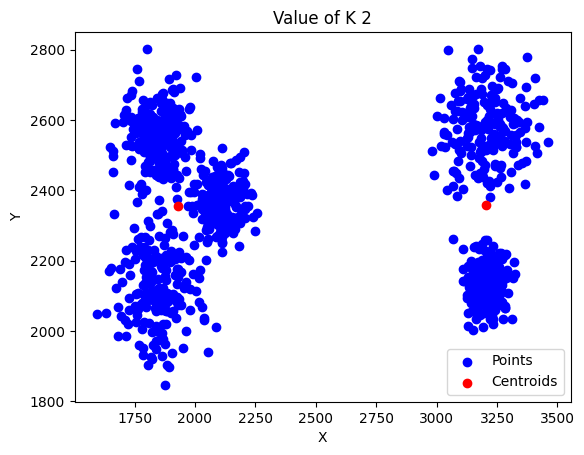

Final centers: [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]
[array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]


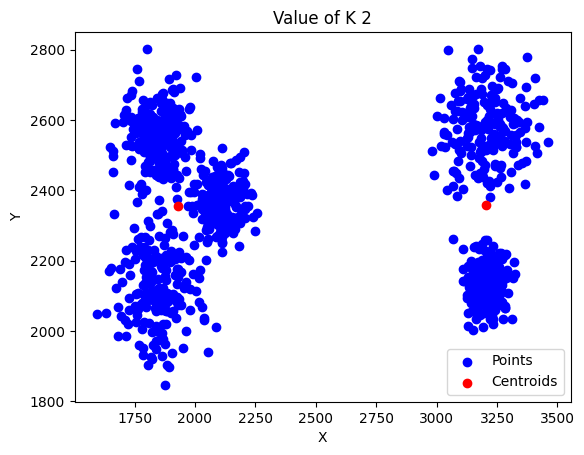

Final centers: [array([3204.11311054, 2359.28791774]), array([1928.50081833, 2355.99181669])]
[array([3204.11311054, 2359.28791774]), array([1928.50081833, 2355.99181669])]


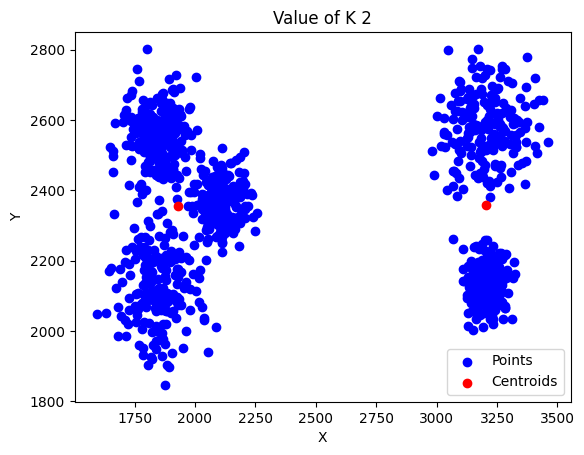

Final centers: [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]
[array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]


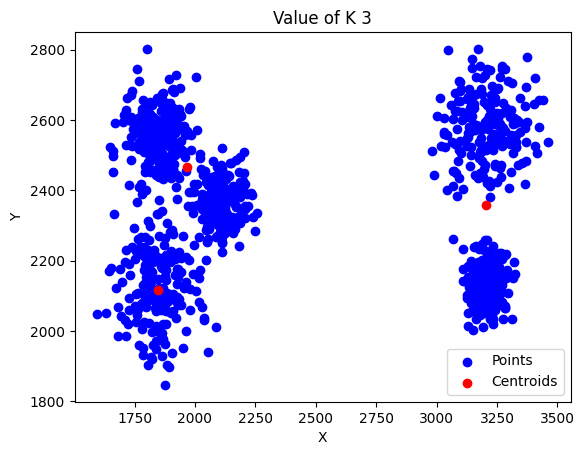

Final centers: [array([3204.11311054, 2359.28791774]), array([1965.82816229, 2466.07398568]), array([1847.04166667, 2115.76041667])]
[array([3204.11311054, 2359.28791774]), array([1965.82816229, 2466.07398568]), array([1847.04166667, 2115.76041667])]


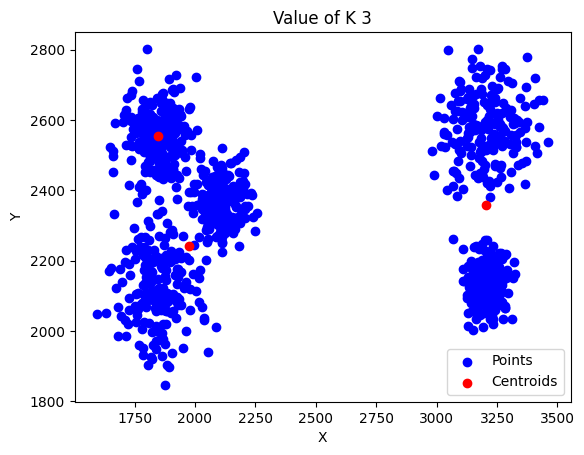

Final centers: [array([3204.11311054, 2359.28791774]), array([1847.56      , 2554.22666667]), array([1975.68134715, 2240.44041451])]
[array([3204.11311054, 2359.28791774]), array([1847.56      , 2554.22666667]), array([1975.68134715, 2240.44041451])]


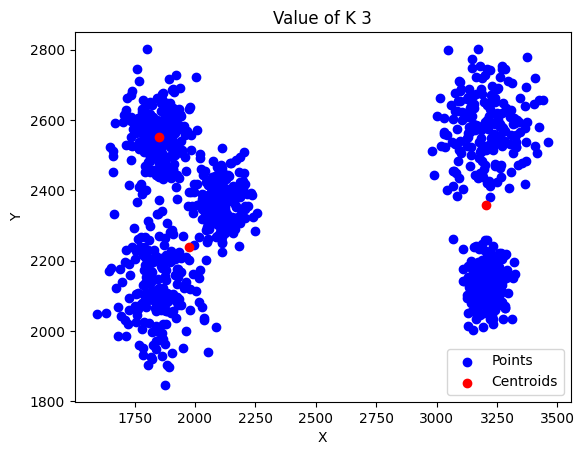

Final centers: [array([3204.11311054, 2359.28791774]), array([1974.59580052, 2237.66141732]), array([1852.14347826, 2552.00869565])]
[array([3204.11311054, 2359.28791774]), array([1974.59580052, 2237.66141732]), array([1852.14347826, 2552.00869565])]


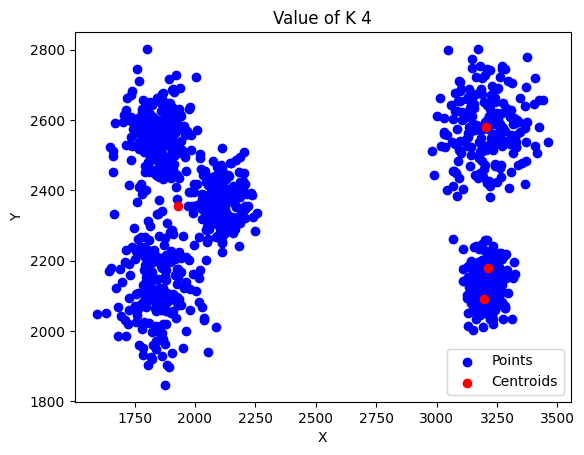

Final centers: [array([3204.63636364, 2579.03030303]), array([1928.50081833, 2355.99181669]), array([3195.76699029, 2091.30097087]), array([3212.70454545, 2178.53409091])]
[array([3204.63636364, 2579.03030303]), array([1928.50081833, 2355.99181669]), array([3195.76699029, 2091.30097087]), array([3212.70454545, 2178.53409091])]


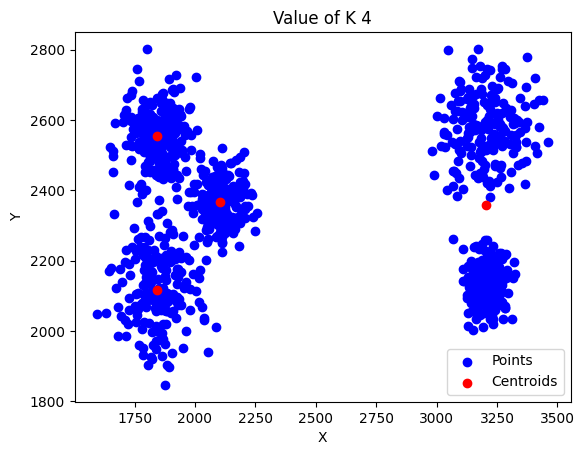

Final centers: [array([1842.98181818, 2555.3       ]), array([3204.11311054, 2359.28791774]), array([2103.75376884, 2366.14572864]), array([1844.84895833, 2117.09375   ])]
[array([1842.98181818, 2555.3       ]), array([3204.11311054, 2359.28791774]), array([2103.75376884, 2366.14572864]), array([1844.84895833, 2117.09375   ])]


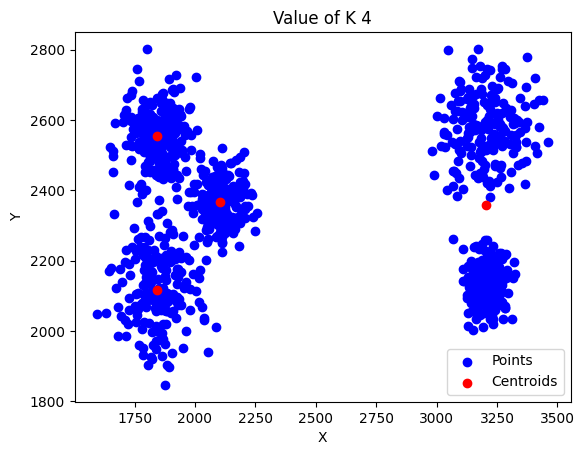

Final centers: [array([1842.98181818, 2555.3       ]), array([3204.11311054, 2359.28791774]), array([1844.84895833, 2117.09375   ]), array([2103.75376884, 2366.14572864])]
[array([1842.98181818, 2555.3       ]), array([3204.11311054, 2359.28791774]), array([1844.84895833, 2117.09375   ]), array([2103.75376884, 2366.14572864])]


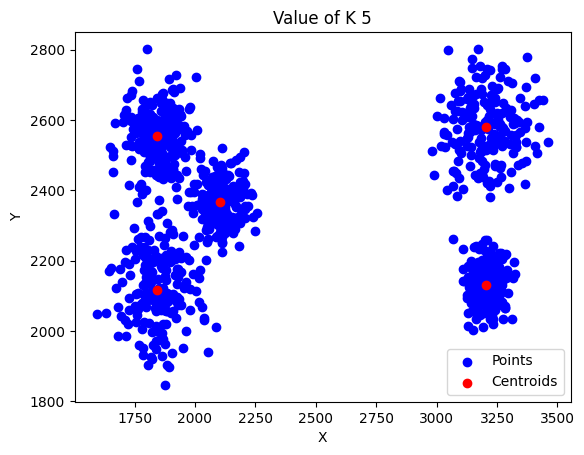

Final centers: [array([3204.63636364, 2579.03030303]), array([1844.84895833, 2117.09375   ]), array([1842.98181818, 2555.3       ]), array([3203.57068063, 2131.4921466 ]), array([2103.75376884, 2366.14572864])]
[array([3204.63636364, 2579.03030303]), array([1844.84895833, 2117.09375   ]), array([1842.98181818, 2555.3       ]), array([3203.57068063, 2131.4921466 ]), array([2103.75376884, 2366.14572864])]


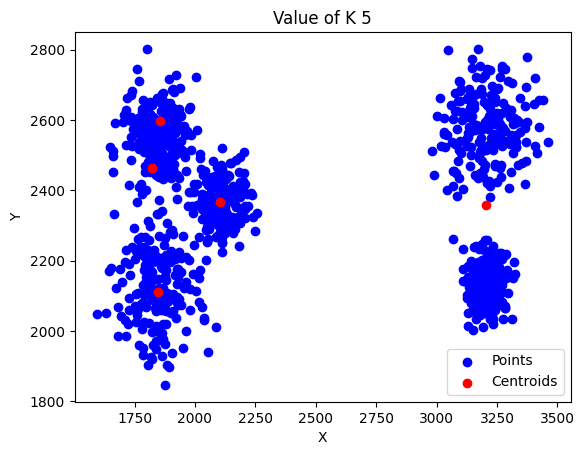

Final centers: [array([1846.49189189, 2109.59459459]), array([1853.9375    , 2596.82638889]), array([1821.71428571, 2461.96428571]), array([3204.11311054, 2359.28791774]), array([2104.65656566, 2366.1010101 ])]
[array([1846.49189189, 2109.59459459]), array([1853.9375    , 2596.82638889]), array([1821.71428571, 2461.96428571]), array([3204.11311054, 2359.28791774]), array([2104.65656566, 2366.1010101 ])]


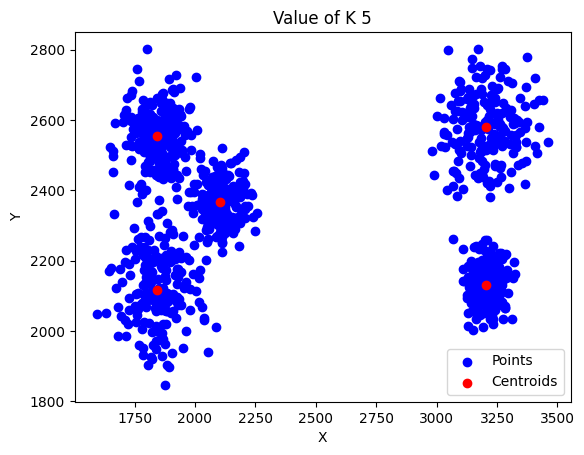

Final centers: [array([3203.57068063, 2131.4921466 ]), array([1842.98181818, 2555.3       ]), array([1844.84895833, 2117.09375   ]), array([3204.63636364, 2579.03030303]), array([2103.75376884, 2366.14572864])]
[array([3203.57068063, 2131.4921466 ]), array([1842.98181818, 2555.3       ]), array([1844.84895833, 2117.09375   ]), array([3204.63636364, 2579.03030303]), array([2103.75376884, 2366.14572864])]

Results:

K = 2:
Avg WSSE: 59970228.48502398
Avg BSSE: 813598.7921587018
Avg SC: 0.4582996322804281

K = 3:
Avg WSSE: 43081080.81606198
Avg BSSE: 1178232.5241455236
Avg SC: 0.4940158728600719

K = 4:
Avg WSSE: 34166540.909176774
Avg BSSE: 1358950.3993234576
Avg SC: 0.6235601471007751

K = 5:
Avg WSSE: 17902705.081661843
Avg BSSE: 1967809.6500245773
Avg SC: 0.6497481353716842

Best K: 5


In [ ]:
results = {}

for k in k_values:
    wsses = []
    bsses = []
    scs = []


    for _ in range(num_runs):

        centroids = kmeans(data, k, max_iterations)
        print(centroids)

        clustered_points = data.map(lambda point: (closest_centroid(point, centroids), point))
        sc = silhouette_coefficient_kmeans(data, centroids)

        wsse = calculate_wsse(data, centroids)
        bsse = calculate_bsse(centroids)

        wsses.append(wsse)
        bsses.append(bsse)
        scs.append(sc)

    results[k] = {
        "WSSE": wsses,
        "BSSES": bsses,
        "SC": scs,
    }
best_k = min(results, key=lambda k: min(results[k]["WSSE"]))

print("\nResults:")
for k, v in results.items():
    print(f"\nK = {k}:")
    print(f"Avg WSSE: {sum(v['WSSE']) / num_runs}")
    print(f"Avg BSSE: {sum(v['BSSES']) / num_runs}")
    print(f"Avg SC: {sum(v['SC']) / num_runs}")

print(f"\nBest K: {best_k}")

# # Plot clustering results
# for k, metrics in results.items():
#     print(f"Results for K = {k}:")
#     for i, predictions in enumerate(metrics["Predictions"]):
#         # Extract cluster labels
#         cluster_labels = predictions.map(lambda pair: pair[0]).collect()

#         # Plot
#         plt.figure(figsize=(8, 6))
#         plt.scatter(data.select("x").collect(), data.select("y").collect(), c=cluster_labels, cmap='viridis', s=50, alpha=0.5)
#         plt.title(f'Custom K-means Clustering Results for K={k}, Run {i+1}')
#         plt.xlabel('X')
#         plt.ylabel('Y')
#         plt.show()

# Stop Spark session
spark.stop()


## 2. Custom Bisecting Kmeans Clustering on dataset DS1

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("CutomBisectingKmeans").getOrCreate()

In [ ]:
lines = spark.read.text("DS1.txt").rdd.map(lambda r: r[0])
data = lines.map(lambda x: parseVector(x)).cache()

In [ ]:
def bisecting_kmeans(points, k, max_iterations=20):
    clusters = [points.collect()]
    iteration = 0

    while len(clusters) < k:
        cluster_to_bisect = max(clusters, key=len)

        cluster_to_bisect = spark.sparkContext.parallelize(cluster_to_bisect)

        k_points = kmeans(cluster_to_bisect, k, max_iterations)

        closest = cluster_to_bisect.map(lambda p: (closestPoint(p, k_points), p))
        split_clusters = closest.groupByKey().map(lambda x: list(x[1])).collect()

        clusters = [c for c in clusters if not np.array_equal(c, cluster_to_bisect.collect())]
        clusters.extend(split_clusters)

        iteration += 1
    clustered_points = [point for cluster in clusters for point in cluster]


    return clusters


In [ ]:
import numpy as np

def calculate_bsse_bisect(centroids):
    bsse = 0
    for centroid in centroids:
        centroid = np.array(centroid)  # Convert to NumPy array
        for point in centroid:
            bsse += np.linalg.norm(point - centroid) ** 2
    return bsse


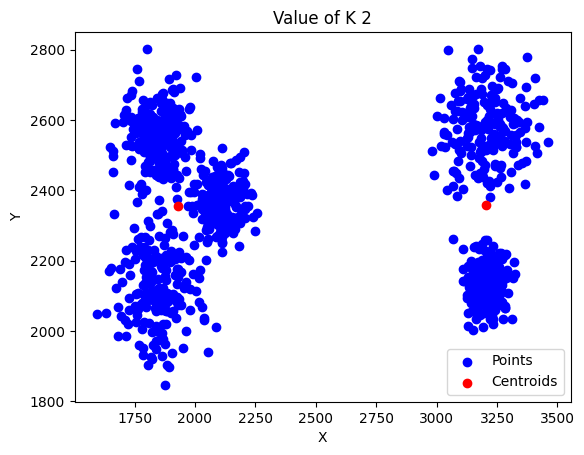

Final centers: [array([3204.11311054, 2359.28791774]), array([1928.50081833, 2355.99181669])]


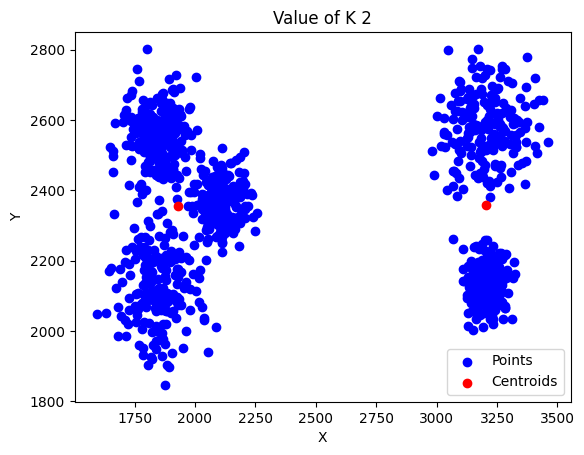

Final centers: [array([3204.11311054, 2359.28791774]), array([1928.50081833, 2355.99181669])]


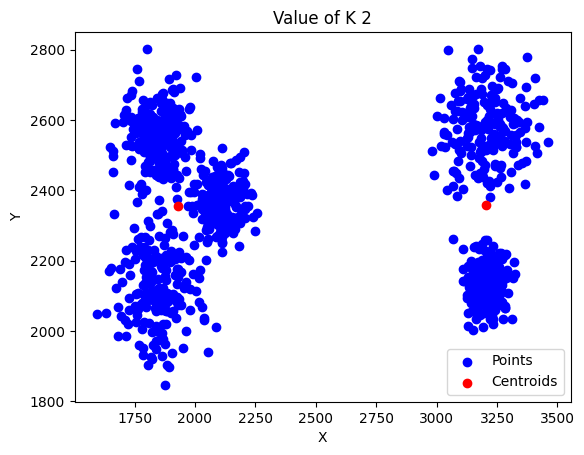

Final centers: [array([1928.50081833, 2355.99181669]), array([3204.11311054, 2359.28791774])]


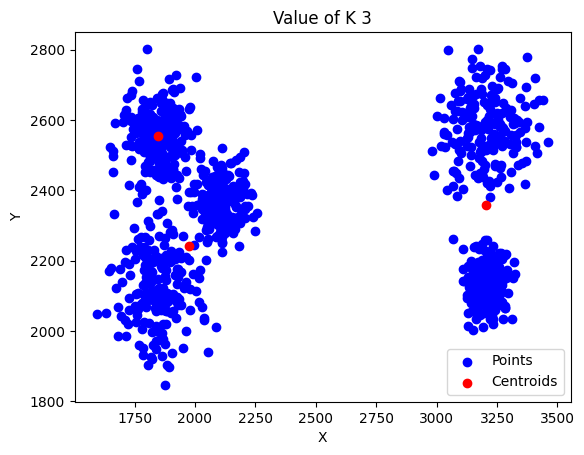

Final centers: [array([3204.11311054, 2359.28791774]), array([1847.56      , 2554.22666667]), array([1975.68134715, 2240.44041451])]


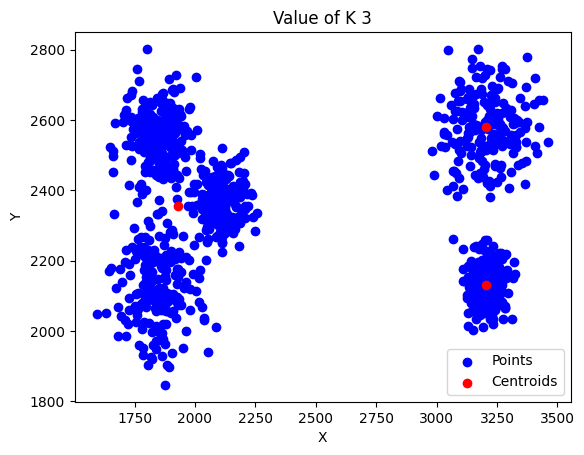

Final centers: [array([3203.57068063, 2131.4921466 ]), array([3204.63636364, 2579.03030303]), array([1928.50081833, 2355.99181669])]


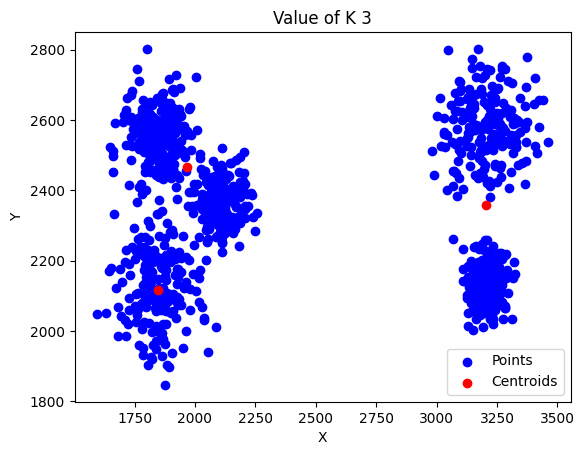

Final centers: [array([1847.04166667, 2115.76041667]), array([3204.11311054, 2359.28791774]), array([1965.82816229, 2466.07398568])]


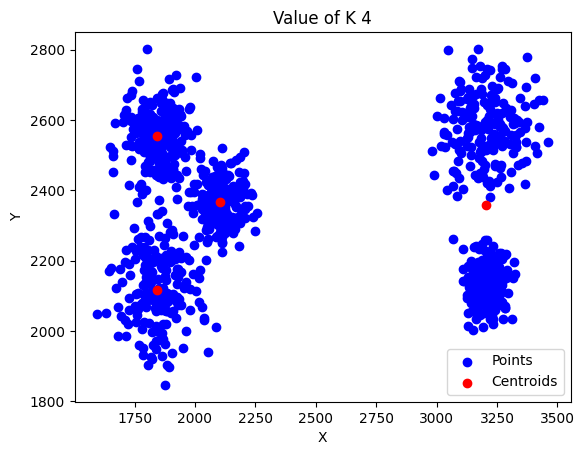

Final centers: [array([2103.75376884, 2366.14572864]), array([1842.98181818, 2555.3       ]), array([1844.84895833, 2117.09375   ]), array([3204.11311054, 2359.28791774])]


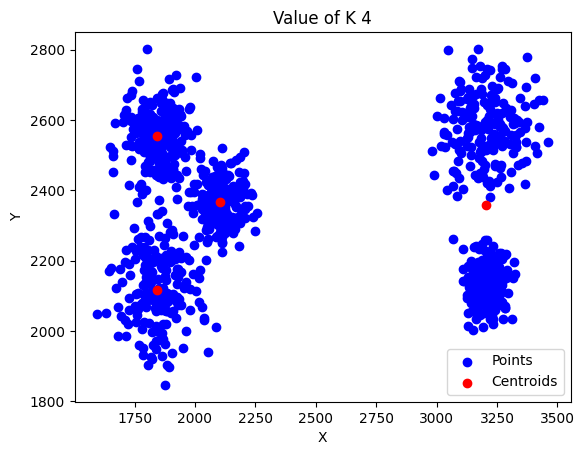

Final centers: [array([2103.75376884, 2366.14572864]), array([1844.84895833, 2117.09375   ]), array([1842.98181818, 2555.3       ]), array([3204.11311054, 2359.28791774])]


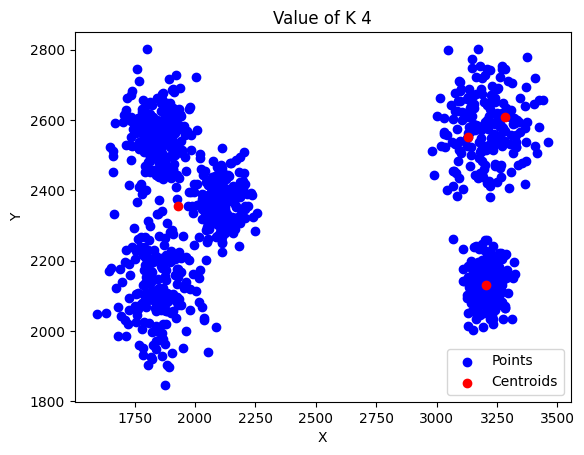

Final centers: [array([3282.64948454, 2607.75257732]), array([1928.50081833, 2355.99181669]), array([3203.57068063, 2131.4921466 ]), array([3129.71287129, 2551.44554455])]


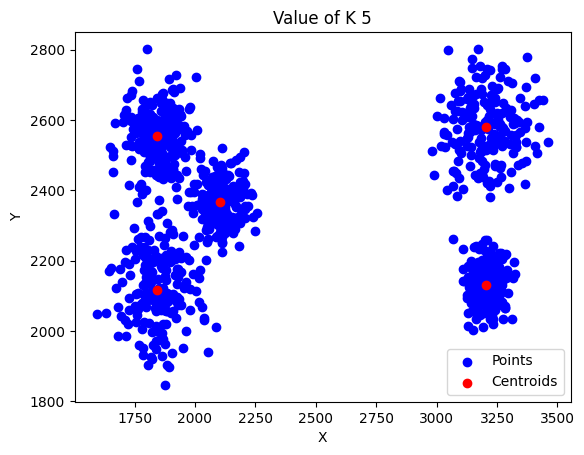

Final centers: [array([1842.98181818, 2555.3       ]), array([3204.63636364, 2579.03030303]), array([2103.75376884, 2366.14572864]), array([1844.84895833, 2117.09375   ]), array([3203.57068063, 2131.4921466 ])]


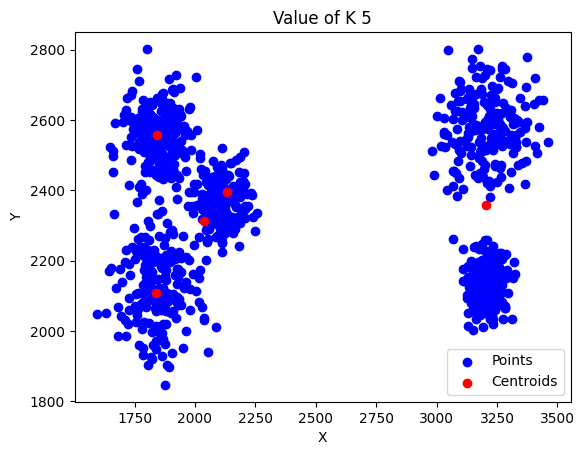

Final centers: [array([1841.71232877, 2555.92694064]), array([2130.96721311, 2394.45081967]), array([1839.3988764 , 2106.79775281]), array([2039.        , 2311.19565217]), array([3204.11311054, 2359.28791774])]


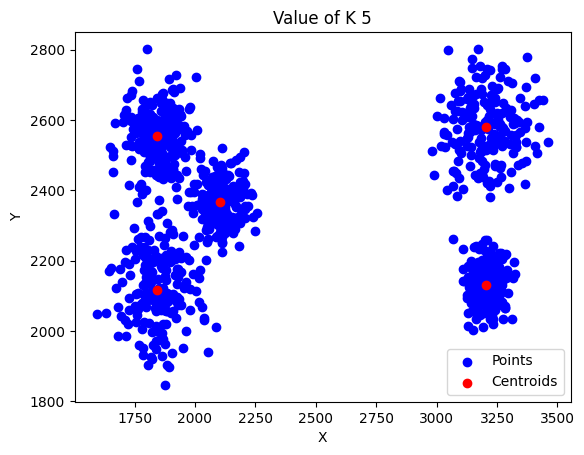

Final centers: [array([2103.75376884, 2366.14572864]), array([1844.84895833, 2117.09375   ]), array([1842.98181818, 2555.3       ]), array([3203.57068063, 2131.4921466 ]), array([3204.63636364, 2579.03030303])]

Results:

K = 2:
Avg WSSE: 62572838144.0
Avg BSSE: 62572838144.0
Avg SC: 0.739329921971659

K = 3:
Avg WSSE: 36053697913.0
Avg BSSE: 36951470726.0
Avg SC: 0.4042667564555488

K = 4:
Avg WSSE: 29281489657.333332
Avg BSSE: 29305078828.0
Avg SC: 0.28319400310104953

K = 5:
Avg WSSE: 10110332631.0
Avg BSSE: 10151238881.333334
Avg SC: 0.29978134990907807

Best K: 5


In [ ]:
results = {}

for k in k_values:
    wsses = []
    bsses = []
    scs = []


    for _ in range(num_runs):

        centroids = bisecting_kmeans(data, k, max_iterations)
        sc = silhouette_coefficient_kmeans(data, centroids)

        wsse = calculate_wsse(data, centroids)
        bsse = calculate_bsse_bisect(centroids)

        wsses.append(wsse)
        bsses.append(bsse)
        scs.append(sc)

    results[k] = {
        "WSSE": wsses,
        "BSSES": bsses,
        "SC": scs,
    }
best_k = min(results, key=lambda k: min(results[k]["WSSE"]))

print("\nResults:")
for k, v in results.items():
    print(f"\nK = {k}:")
    print(f"Avg WSSE: {sum(v['WSSE']) / num_runs}")
    print(f"Avg BSSE: {sum(v['BSSES']) / num_runs}")
    print(f"Avg SC: {sum(v['SC']) / num_runs}")

print(f"\nBest K: {best_k}")

spark.stop()


## 3. K-MEANS clustering using PYSPARK MLLIB Kmeans function on DS2, DS3

In [ ]:
from pyspark.sql import SparkSession
from pyspark.ml.clustering import KMeans
from pyspark.ml.feature import VectorAssembler
from pyspark.ml.evaluation import ClusteringEvaluator
from pyspark.sql.types import StructType, StructField, StringType
import time
from pyspark.sql.functions import split

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("MLLIBKmeans").getOrCreate()

In [ ]:
data = spark.read.text("DS2.txt")

parsed_data = data.rdd.map(lambda row: row.value.split(" ")).toDF(["feature1", "feature2"])

parsed_data = parsed_data.select(parsed_data["feature1"].cast("double"), parsed_data["feature2"].cast("double"))

vector_assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
prepared_data = vector_assembler.transform(parsed_data)
prepared_data = prepared_data.na.drop()
prepared_data.cache()


DataFrame[feature1: double, feature2: double, features: vector]

In [ ]:
prepared_data.show()

+--------+--------+-------------------+
|feature1|feature2|           features|
+--------+--------+-------------------+
|147265.0|351837.0|[147265.0,351837.0]|
|149905.0|349644.0|[149905.0,349644.0]|
|149479.0|351115.0|[149479.0,351115.0]|
|151985.0|353649.0|[151985.0,353649.0]|
|153457.0|349093.0|[153457.0,349093.0]|
|153508.0|350082.0|[153508.0,350082.0]|
|147269.0|357194.0|[147269.0,357194.0]|
|150245.0|348533.0|[150245.0,348533.0]|
|146161.0|352594.0|[146161.0,352594.0]|
|146479.0|352222.0|[146479.0,352222.0]|
|149978.0|354997.0|[149978.0,354997.0]|
|154847.0|352140.0|[154847.0,352140.0]|
|147566.0|342000.0|[147566.0,342000.0]|
|151174.0|347435.0|[151174.0,347435.0]|
|149287.0|351539.0|[149287.0,351539.0]|
|153533.0|351164.0|[153533.0,351164.0]|
|146556.0|355830.0|[146556.0,355830.0]|
|150103.0|354435.0|[150103.0,354435.0]|
|151747.0|351738.0|[151747.0,351738.0]|
|153480.0|350609.0|[153480.0,350609.0]|
+--------+--------+-------------------+
only showing top 20 rows



In [ ]:
# kmeans = KMeans().setK(2).setSeed(1)
# model = kmeans.fit(prepared_data)

# predictions = model.transform(prepared_data)

# centers = model.clusterCenters()
# print("Cluster Centers: ")
# print(centers)

# evaluator = ClusteringEvaluator()
# silhouette = evaluator.evaluate(predictions)
# print("Silhouette with squared euclidean distance = " +
# str(silhouette))

# wsse = model.summary.trainingCost
# print("WSSE:", wsse)

# centroid = np.mean(prepared_data.select("features").rdd.map(lambda x: x[0]).collect(), axis=0)
# bsse = sum([np.sum((c - centroid) ** 2) for c in centers])
# print("BSSE:", bsse)


# plot_iteration(np.array(prepared_data.select("feature1", "feature2").collect()), np.array(centers), 2)


In [ ]:
k_values = [4, 5, 6, 7, 8]  # Different values of K to try
num_runs = 3
max_iterations = 20

Running K-means for K = 4
Cluster Centers: 
[array([194951.6125 , 364985.61525]), array([477460.49874687, 362205.0802005 ]), array([539722.84158416, 300612.73267327]), array([150006.7365, 350103.876 ])]
Silhouette with squared euclidean distance = 0.707571350834473
WSSE: 3404478608094.0596
BSSE: 194244817480.2608


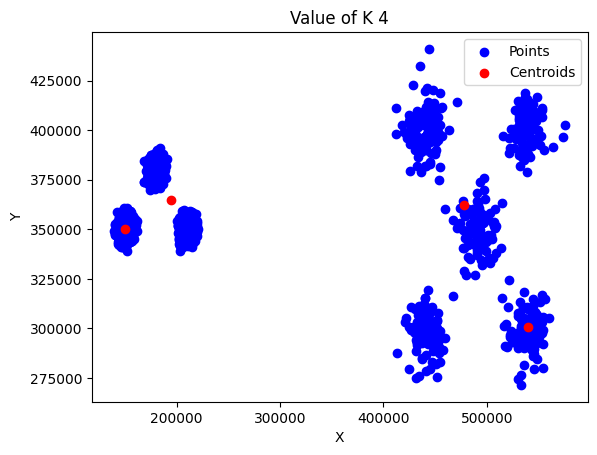

Cluster Centers: 
[array([194951.6125 , 364985.61525]), array([477460.49874687, 362205.0802005 ]), array([539722.84158416, 300612.73267327]), array([150006.7365, 350103.876 ])]
Silhouette with squared euclidean distance = 0.707571350834473
WSSE: 3404478608094.0596
BSSE: 194244817480.2608


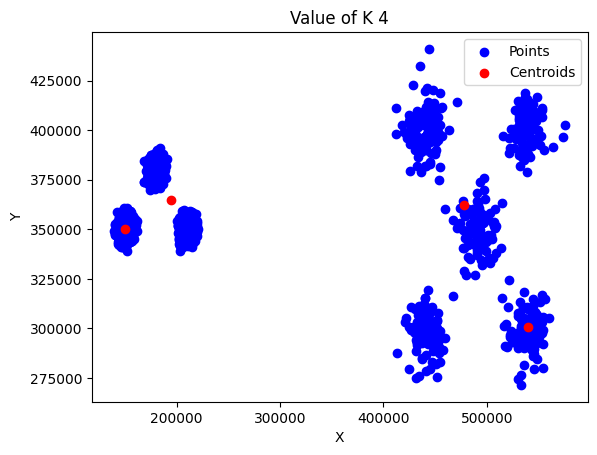

Cluster Centers: 
[array([194951.6125 , 364985.61525]), array([477460.49874687, 362205.0802005 ]), array([539722.84158416, 300612.73267327]), array([150006.7365, 350103.876 ])]
Silhouette with squared euclidean distance = 0.707571350834473
WSSE: 3404478608094.0596
BSSE: 194244817480.2608


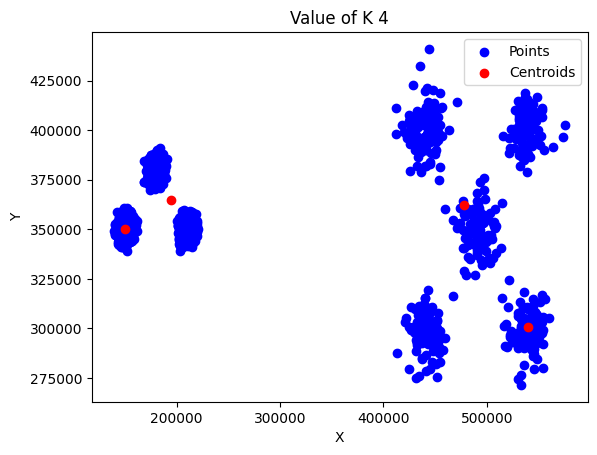

Running K-means for K = 5
Cluster Centers: 
[array([194964.99624812, 364981.08729365]), array([477460.49874687, 362205.0802005 ]), array([539722.84158416, 300612.73267327]), array([148152.99793175, 348015.75180972]), array([151773.83478261, 352101.05700483])]
Silhouette with squared euclidean distance = 0.5248172087194916
WSSE: 3389790245740.8076
BSSE: 197249822873.5015


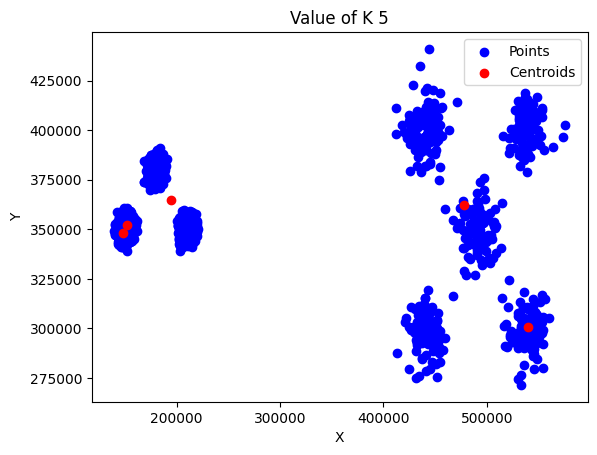

Cluster Centers: 
[array([194964.99624812, 364981.08729365]), array([477460.49874687, 362205.0802005 ]), array([539722.84158416, 300612.73267327]), array([148152.99793175, 348015.75180972]), array([151773.83478261, 352101.05700483])]
Silhouette with squared euclidean distance = 0.5248172087194916
WSSE: 3389790245740.8076
BSSE: 197249822873.5015


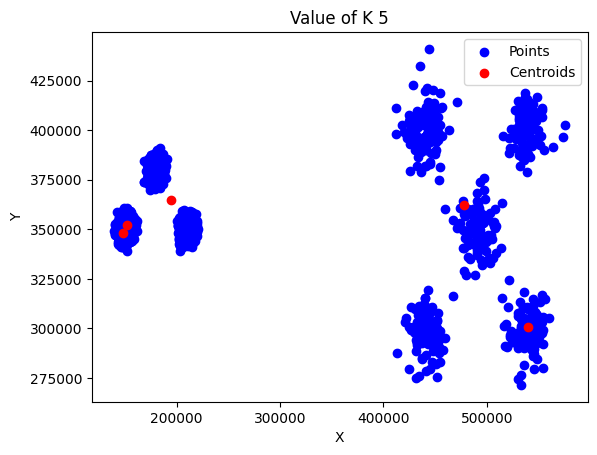

Cluster Centers: 
[array([194964.99624812, 364981.08729365]), array([477460.49874687, 362205.0802005 ]), array([539722.84158416, 300612.73267327]), array([148152.99793175, 348015.75180972]), array([151773.83478261, 352101.05700483])]
Silhouette with squared euclidean distance = 0.5248172087194916
WSSE: 3389790245740.8076
BSSE: 197249822873.5015


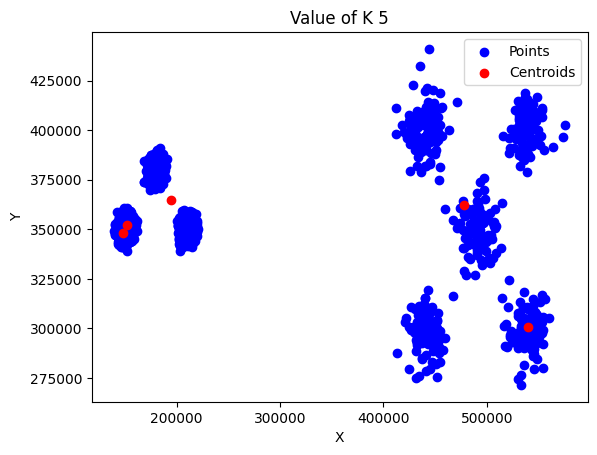

Running K-means for K = 6
Cluster Centers: 
[array([539379.19, 299652.83]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([490224.62      , 349676.29666667]), array([179954.98  , 380007.9705])]
Silhouette with squared euclidean distance = 0.9346752632223019
WSSE: 1223056433655.749
BSSE: 259888081578.61853


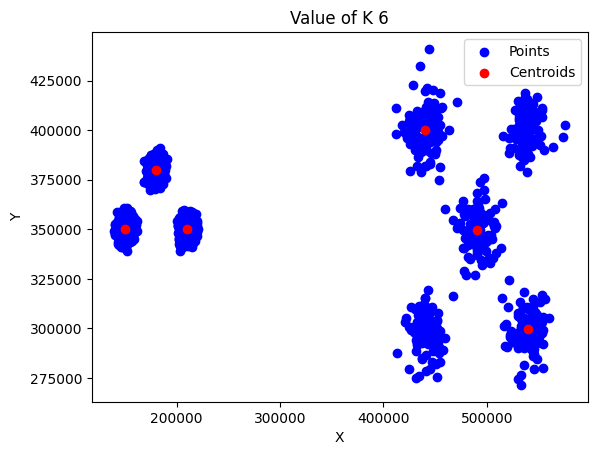

Cluster Centers: 
[array([539379.19, 299652.83]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([490224.62      , 349676.29666667]), array([179954.98  , 380007.9705])]
Silhouette with squared euclidean distance = 0.9346752632223019
WSSE: 1223056433655.749
BSSE: 259888081578.61853


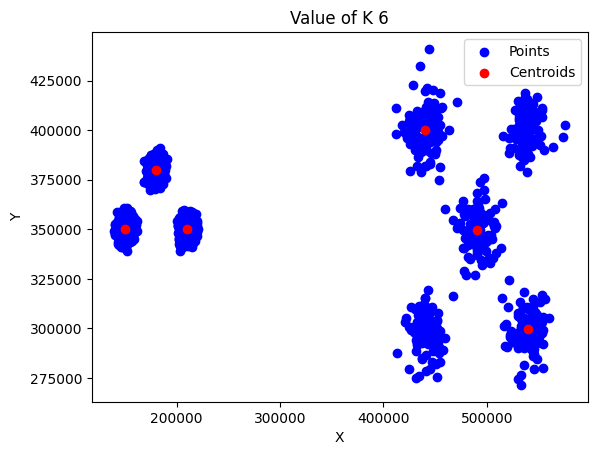

Cluster Centers: 
[array([539379.19, 299652.83]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([490224.62      , 349676.29666667]), array([179954.98  , 380007.9705])]
Silhouette with squared euclidean distance = 0.9346752632223019
WSSE: 1223056433655.749
BSSE: 259888081578.61853


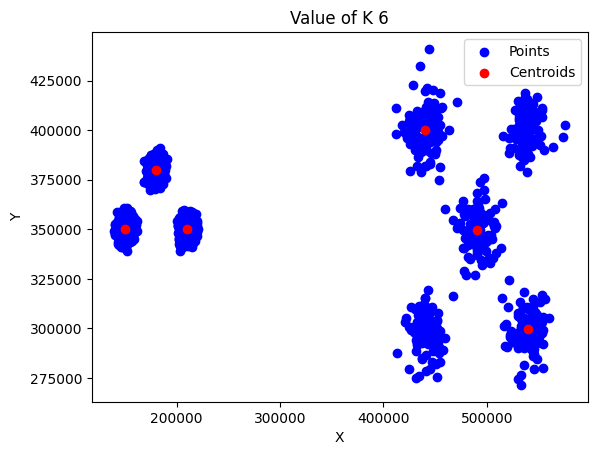

Running K-means for K = 7
Cluster Centers: 
[array([539122.03960396, 300058.98019802]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([464541.38860104, 322585.76683938]), array([179954.98  , 380007.9705]), array([536768.78301887, 399086.43396226])]
Silhouette with squared euclidean distance = 0.9602680318560004
WSSE: 467403158539.18555
BSSE: 359309361347.8365


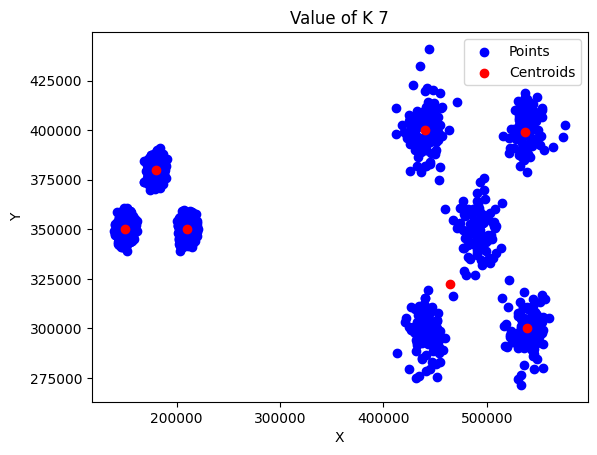

Cluster Centers: 
[array([539122.03960396, 300058.98019802]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([464541.38860104, 322585.76683938]), array([179954.98  , 380007.9705]), array([536768.78301887, 399086.43396226])]
Silhouette with squared euclidean distance = 0.9602680318560004
WSSE: 467403158539.18555
BSSE: 359309361347.8365


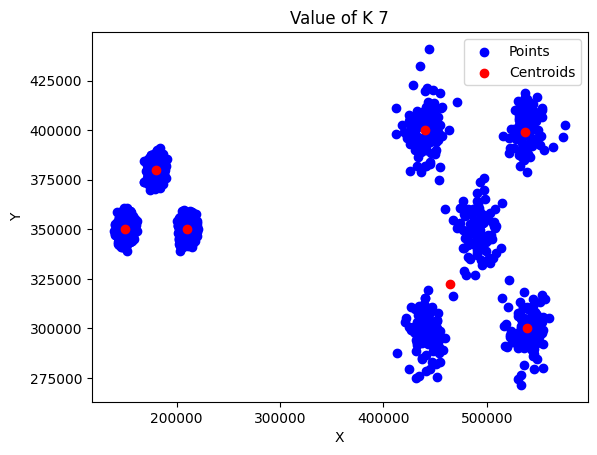

Cluster Centers: 
[array([539122.03960396, 300058.98019802]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([464541.38860104, 322585.76683938]), array([179954.98  , 380007.9705]), array([536768.78301887, 399086.43396226])]
Silhouette with squared euclidean distance = 0.9602680318560004
WSSE: 467403158539.18555
BSSE: 359309361347.8365


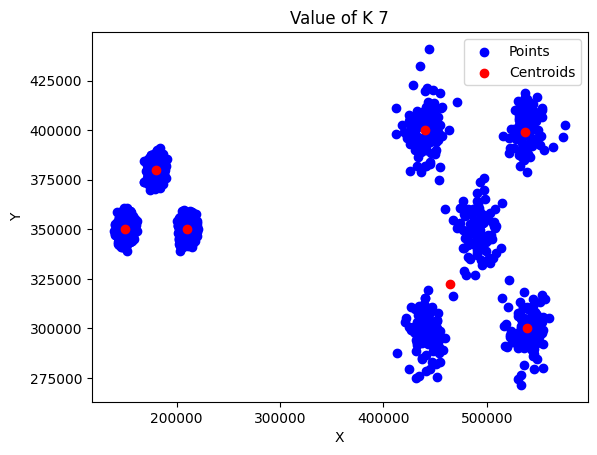

Running K-means for K = 8
Cluster Centers: 
[array([539379.19, 299652.83]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([491036.01, 349798.33]), array([179954.98  , 380007.9705]), array([538883.52, 400947.36]), array([440754.33, 298283.2 ])]
Silhouette with squared euclidean distance = 0.9724023548273677
WSSE: 214492062847.6834
BSSE: 434210173757.1145


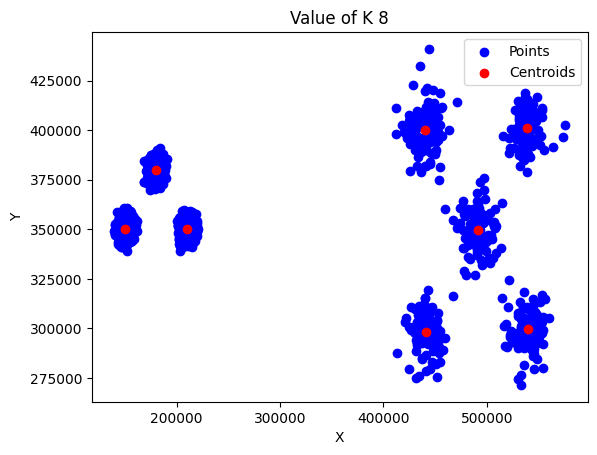

Cluster Centers: 
[array([539379.19, 299652.83]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([491036.01, 349798.33]), array([179954.98  , 380007.9705]), array([538883.52, 400947.36]), array([440754.33, 298283.2 ])]
Silhouette with squared euclidean distance = 0.9724023548273677
WSSE: 214492062847.6834
BSSE: 434210173757.1145


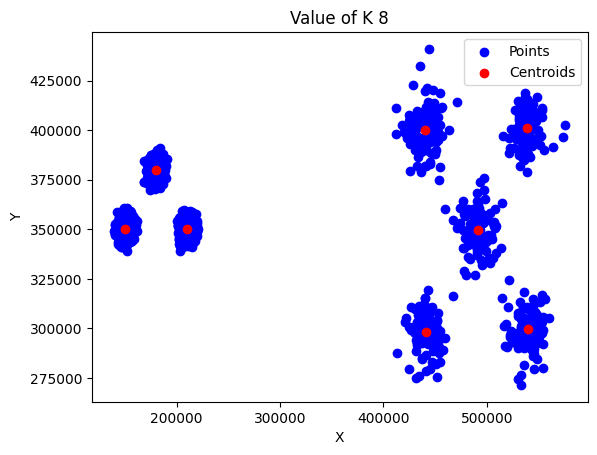

Cluster Centers: 
[array([539379.19, 299652.83]), array([150006.7365, 350103.876 ]), array([209948.245, 349963.26 ]), array([440134.41, 400135.41]), array([491036.01, 349798.33]), array([179954.98  , 380007.9705]), array([538883.52, 400947.36]), array([440754.33, 298283.2 ])]
Silhouette with squared euclidean distance = 0.9724023548273677
WSSE: 214492062847.6834
BSSE: 434210173757.1145


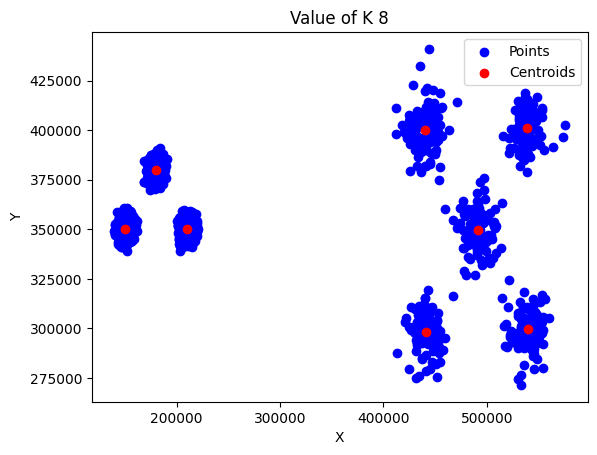

{4: {'WSSE': [3404478608094.0596, 3404478608094.0596, 3404478608094.0596], 'BSSE': [194244817480.2608, 194244817480.2608, 194244817480.2608], 'SC': [0.707571350834473, 0.707571350834473, 0.707571350834473]}, 5: {'WSSE': [3389790245740.8076, 3389790245740.8076, 3389790245740.8076], 'BSSE': [197249822873.5015, 197249822873.5015, 197249822873.5015], 'SC': [0.5248172087194916, 0.5248172087194916, 0.5248172087194916]}, 6: {'WSSE': [1223056433655.749, 1223056433655.749, 1223056433655.749], 'BSSE': [259888081578.61853, 259888081578.61853, 259888081578.61853], 'SC': [0.9346752632223019, 0.9346752632223019, 0.9346752632223019]}, 7: {'WSSE': [467403158539.18555, 467403158539.18555, 467403158539.18555], 'BSSE': [359309361347.8365, 359309361347.8365, 359309361347.8365], 'SC': [0.9602680318560004, 0.9602680318560004, 0.9602680318560004]}, 8: {'WSSE': [214492062847.6834, 214492062847.6834, 214492062847.6834], 'BSSE': [434210173757.1145, 434210173757.1145, 434210173757.1145], 'SC': [0.972402354827367

In [ ]:
results = {}
for k in k_values:
    print(f"Running K-means for K = {k}")

    wsse_list = []
    bsse_list = []
    sc_list = []

    for run in range(num_runs):
        kmeans = KMeans().setK(k).setSeed(1)
        model = kmeans.fit(prepared_data)

        predictions = model.transform(prepared_data)

        centers = model.clusterCenters()
        print("Cluster Centers: ")
        print(centers)

        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        print("Silhouette with squared euclidean distance = " +
        str(silhouette))

        wsse = model.summary.trainingCost
        print("WSSE:", wsse)

        centroid = np.mean(prepared_data.select("features").rdd.map(lambda x: x[0]).collect(), axis=0)
        bsse = sum([np.sum((c - centroid) ** 2) for c in centers])
        print("BSSE:", bsse)


        plot_iteration(np.array(prepared_data.select("feature1", "feature2").collect()), np.array(centers), k)

        wsse_list.append(wsse)

        bsse_list.append(bsse)

        sc_list.append(silhouette)



    results[k] = {
        "WSSE": wsse_list,
        "BSSE": bsse_list,
        "SC": sc_list,
    }

print(results)

best_k = min(results, key=lambda k: min(results[k]["WSSE"]))

print("\nResults:")
for k, v in results.items():
    print(f"\nK = {k}:")
    print(f"Avg WSSE: {sum(v['WSSE']) / num_runs}")
    print(f"Avg BSSE: {sum(v['BSSE']) / num_runs}")
    print(f"Avg SC: {sum(v['SC']) / num_runs}")

print(f"\nBest K: {best_k}")

spark.stop()

## 4. Bisecting K-MEANS clustering using PYSPARK MLLIB Kmeans function on DS2, DS3

In [ ]:
from pyspark.ml.clustering import BisectingKMeans

In [ ]:
spark = SparkSession.builder.master("local[*]").appName("MLLIBKmeans").getOrCreate()

In [ ]:
data = spark.read.text("DS2.txt")

parsed_data = data.rdd.map(lambda row: row.value.split(" ")).toDF(["feature1", "feature2"])

parsed_data = parsed_data.select(parsed_data["feature1"].cast("double"), parsed_data["feature2"].cast("double"))

vector_assembler = VectorAssembler(inputCols=["feature1", "feature2"], outputCol="features")
prepared_data = vector_assembler.transform(parsed_data)
prepared_data = prepared_data.na.drop()
prepared_data.cache()


DataFrame[feature1: double, feature2: double, features: vector]

In [ ]:
prepared_data.show()

+--------+--------+-------------------+
|feature1|feature2|           features|
+--------+--------+-------------------+
|147265.0|351837.0|[147265.0,351837.0]|
|149905.0|349644.0|[149905.0,349644.0]|
|149479.0|351115.0|[149479.0,351115.0]|
|151985.0|353649.0|[151985.0,353649.0]|
|153457.0|349093.0|[153457.0,349093.0]|
|153508.0|350082.0|[153508.0,350082.0]|
|147269.0|357194.0|[147269.0,357194.0]|
|150245.0|348533.0|[150245.0,348533.0]|
|146161.0|352594.0|[146161.0,352594.0]|
|146479.0|352222.0|[146479.0,352222.0]|
|149978.0|354997.0|[149978.0,354997.0]|
|154847.0|352140.0|[154847.0,352140.0]|
|147566.0|342000.0|[147566.0,342000.0]|
|151174.0|347435.0|[151174.0,347435.0]|
|149287.0|351539.0|[149287.0,351539.0]|
|153533.0|351164.0|[153533.0,351164.0]|
|146556.0|355830.0|[146556.0,355830.0]|
|150103.0|354435.0|[150103.0,354435.0]|
|151747.0|351738.0|[151747.0,351738.0]|
|153480.0|350609.0|[153480.0,350609.0]|
+--------+--------+-------------------+
only showing top 20 rows



Running Bisecting K-means for K = 4
Cluster Centers: 
[array([150006.7365, 350103.876 ]), array([194951.6125 , 364985.61525]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.7189355963485206
WSSE: 3131880783349.231


/usr/local/lib/python3.10/dist-packages/pyspark/ml/clustering.py:1016: FutureWarning: Deprecated in 3.0.0. It will be removed in future versions. Use ClusteringEvaluator instead. You can also get the cost on the training dataset in the summary.
  warnings.warn(


BSSE: 170725022484.73953


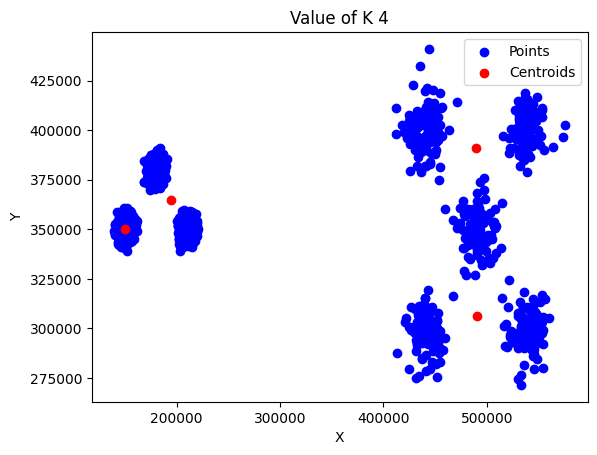

Cluster Centers: 
[array([150006.7365, 350103.876 ]), array([194951.6125 , 364985.61525]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.7189355963485206
WSSE: 3131880783349.231
BSSE: 170725022484.73953


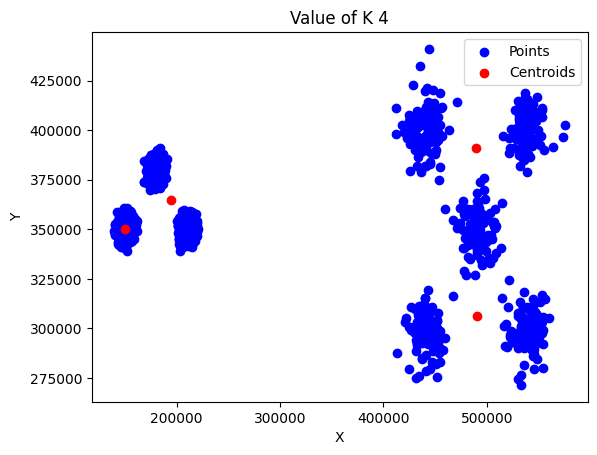

Cluster Centers: 
[array([150006.7365, 350103.876 ]), array([194951.6125 , 364985.61525]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.7189355963485206
WSSE: 3131880783349.231
BSSE: 170725022484.73953


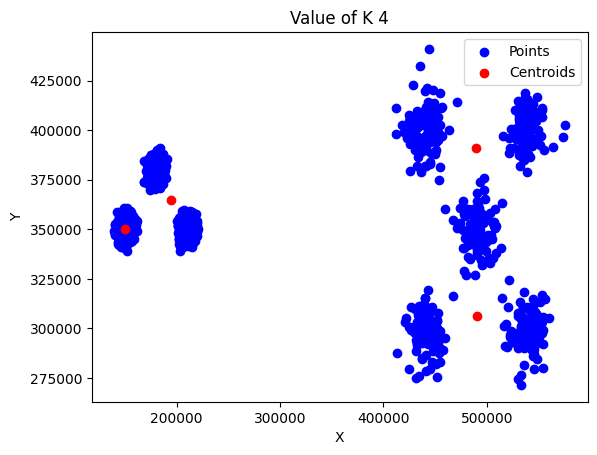

Running Bisecting K-means for K = 5
Cluster Centers: 
[array([150006.7365, 350103.876 ]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.9442594471277921
WSSE: 1329600208960.2395
BSSE: 171737896470.72723


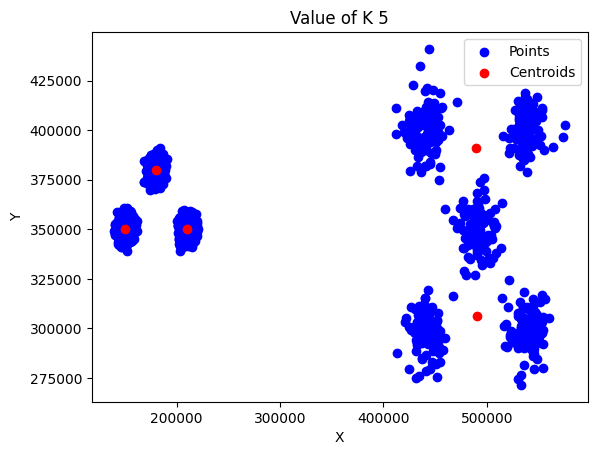

Cluster Centers: 
[array([150006.7365, 350103.876 ]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.9442594471277921
WSSE: 1329600208960.2395
BSSE: 171737896470.72723


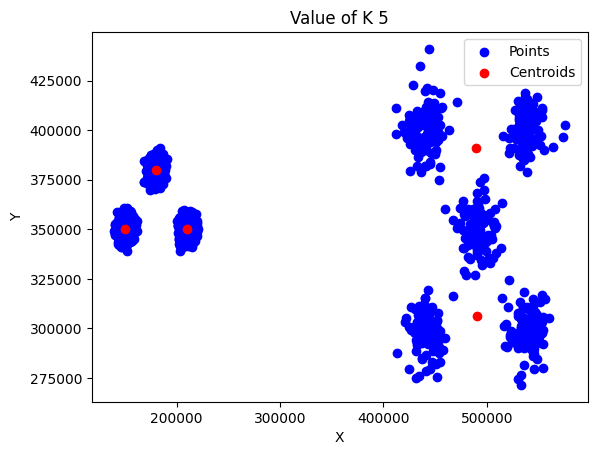

Cluster Centers: 
[array([150006.7365, 350103.876 ]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.9442594471277921
WSSE: 1329600208960.2395
BSSE: 171737896470.72723


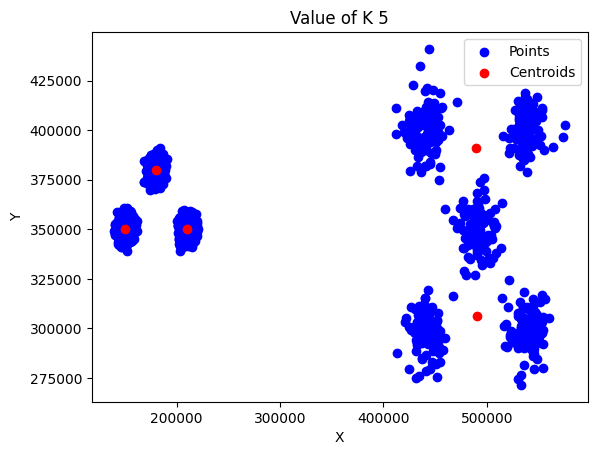

Running Bisecting K-means for K = 6
Cluster Centers: 
[array([148130.57872784, 348005.51303441]), array([151735.10854947, 352036.95004803]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.7933301534372686
WSSE: 1315002229668.3848
BSSE: 174750869173.76517


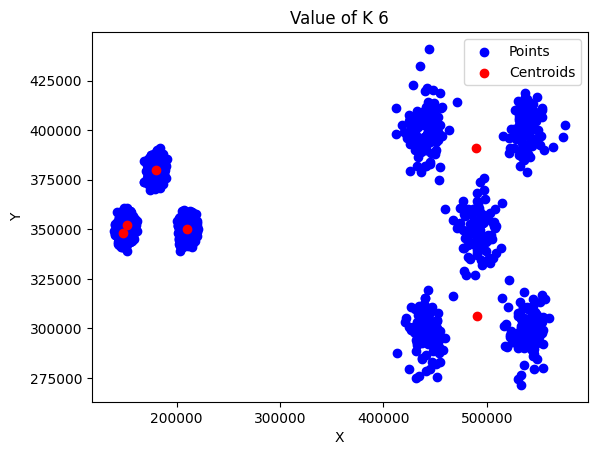

Cluster Centers: 
[array([148130.57872784, 348005.51303441]), array([151735.10854947, 352036.95004803]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.7933301534372686
WSSE: 1315002229668.3848
BSSE: 174750869173.76517


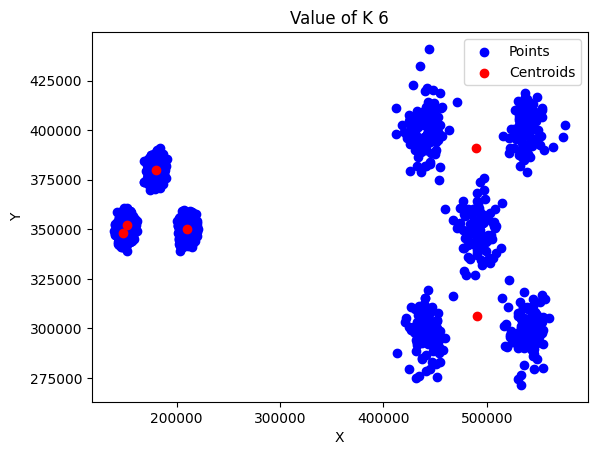

Cluster Centers: 
[array([148130.57872784, 348005.51303441]), array([151735.10854947, 352036.95004803]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([489705.18359375, 390969.98828125])]
Silhouette with squared euclidean distance = 0.7933301534372686
WSSE: 1315002229668.3848
BSSE: 174750869173.76517


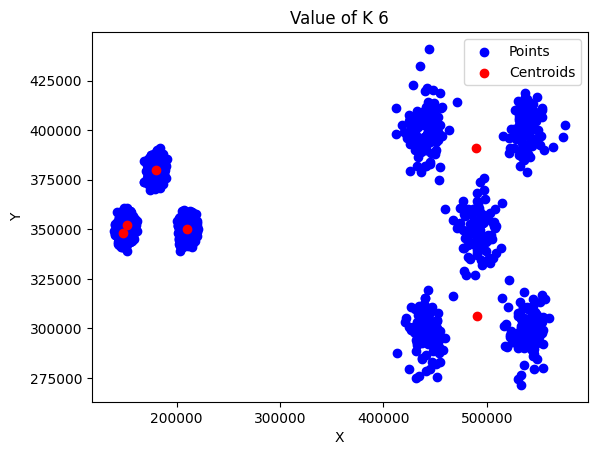

Running Bisecting K-means for K = 7
Cluster Centers: 
[array([148130.57872784, 348005.51303441]), array([151735.10854947, 352036.95004803]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([455180.10204082, 386370.73469388]), array([536266.53211009, 397172.65137615])]
Silhouette with squared euclidean distance = 0.7952035170884736
WSSE: 896170364009.0592
BSSE: 267890792522.81213


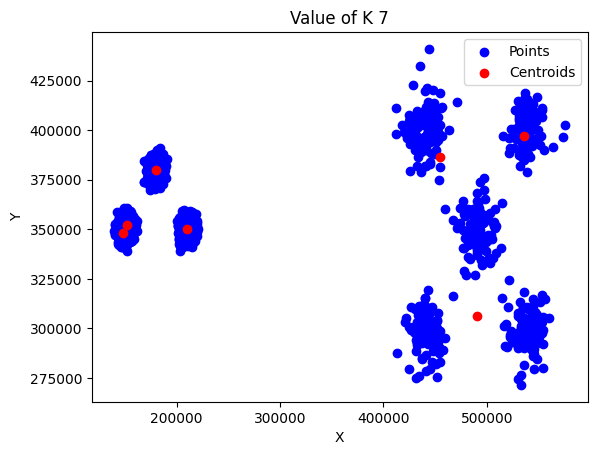

Cluster Centers: 
[array([148130.57872784, 348005.51303441]), array([151735.10854947, 352036.95004803]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([455180.10204082, 386370.73469388]), array([536266.53211009, 397172.65137615])]
Silhouette with squared euclidean distance = 0.7952035170884736
WSSE: 896170364009.0592
BSSE: 267890792522.81213


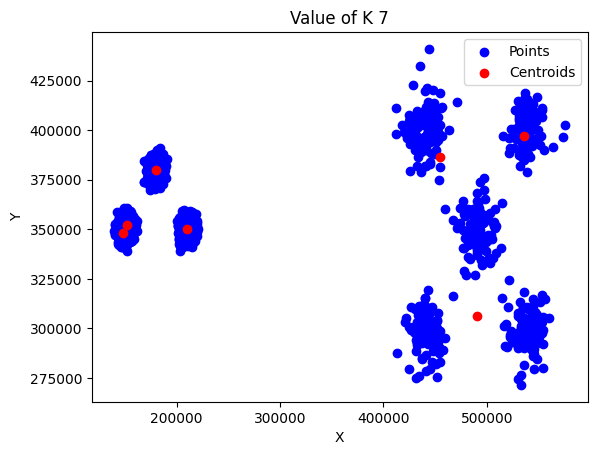

Cluster Centers: 
[array([148130.57872784, 348005.51303441]), array([151735.10854947, 352036.95004803]), array([179954.98  , 380007.9705]), array([209948.245, 349963.26 ]), array([490386.14344262, 306530.31147541]), array([455180.10204082, 386370.73469388]), array([536266.53211009, 397172.65137615])]
Silhouette with squared euclidean distance = 0.7952035170884736
WSSE: 896170364009.0592
BSSE: 267890792522.81213


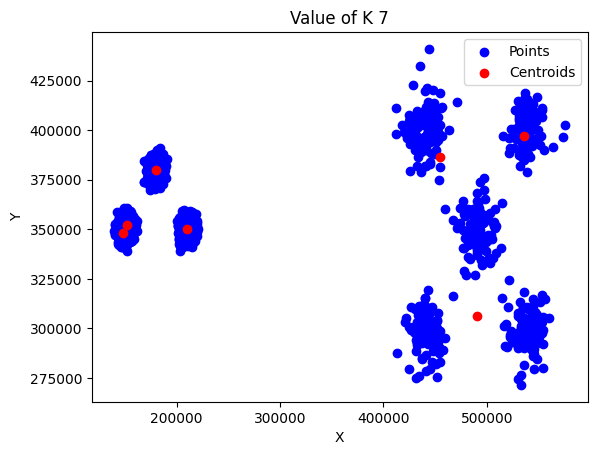

Running Bisecting K-means for K = 8
Cluster Centers: 
[array([148123.51619645, 348004.2539185 ]), array([151734.67689358, 352030.37488015]), array([209948.245, 349963.26 ]), array([179954.98  , 380007.9705]), array([442186.625     , 299664.39423077]), array([526191.5       , 311630.70714286]), array([455180.10204082, 386370.73469388]), array([536266.53211009, 397172.65137615])]
Silhouette with squared euclidean distance = 0.8081755807545979
WSSE: 466530278713.2581
BSSE: 349550008962.0465


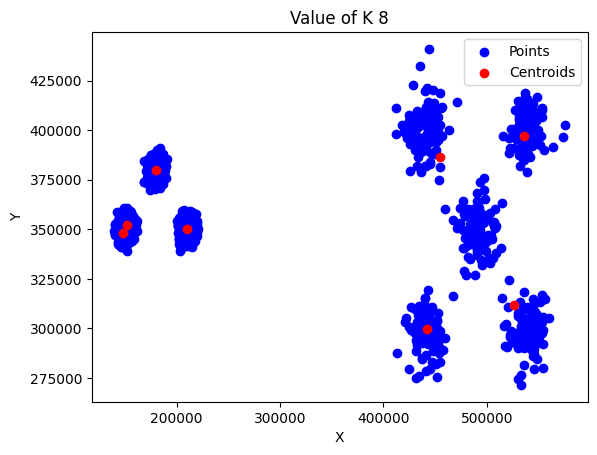

Cluster Centers: 
[array([148123.51619645, 348004.2539185 ]), array([151734.67689358, 352030.37488015]), array([209948.245, 349963.26 ]), array([179954.98  , 380007.9705]), array([442186.625     , 299664.39423077]), array([526191.5       , 311630.70714286]), array([455180.10204082, 386370.73469388]), array([536266.53211009, 397172.65137615])]
Silhouette with squared euclidean distance = 0.8081755807545979
WSSE: 466530278713.2581
BSSE: 349550008962.0465


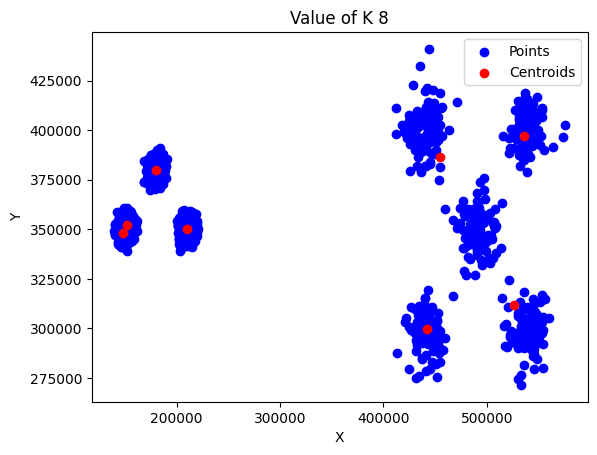

Cluster Centers: 
[array([148123.51619645, 348004.2539185 ]), array([151734.67689358, 352030.37488015]), array([209948.245, 349963.26 ]), array([179954.98  , 380007.9705]), array([442186.625     , 299664.39423077]), array([526191.5       , 311630.70714286]), array([455180.10204082, 386370.73469388]), array([536266.53211009, 397172.65137615])]
Silhouette with squared euclidean distance = 0.8081755807545979
WSSE: 466530278713.2581
BSSE: 349550008962.0465


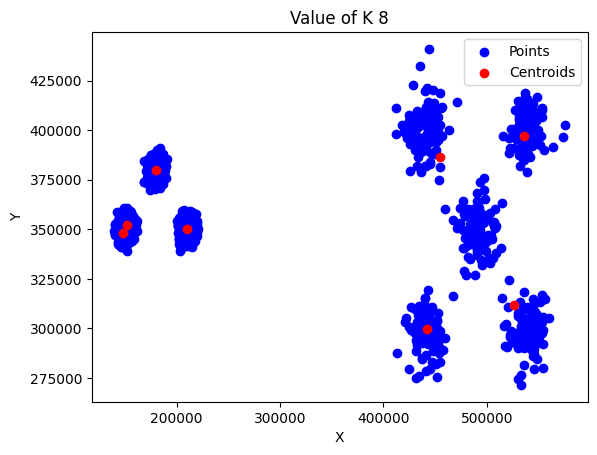

{4: {'WSSE': [3131880783349.231, 3131880783349.231, 3131880783349.231], 'BSSE': [170725022484.73953, 170725022484.73953, 170725022484.73953], 'SC': [0.7189355963485206, 0.7189355963485206, 0.7189355963485206]}, 5: {'WSSE': [1329600208960.2395, 1329600208960.2395, 1329600208960.2395], 'BSSE': [171737896470.72723, 171737896470.72723, 171737896470.72723], 'SC': [0.9442594471277921, 0.9442594471277921, 0.9442594471277921]}, 6: {'WSSE': [1315002229668.3848, 1315002229668.3848, 1315002229668.3848], 'BSSE': [174750869173.76517, 174750869173.76517, 174750869173.76517], 'SC': [0.7933301534372686, 0.7933301534372686, 0.7933301534372686]}, 7: {'WSSE': [896170364009.0592, 896170364009.0592, 896170364009.0592], 'BSSE': [267890792522.81213, 267890792522.81213, 267890792522.81213], 'SC': [0.7952035170884736, 0.7952035170884736, 0.7952035170884736]}, 8: {'WSSE': [466530278713.2581, 466530278713.2581, 466530278713.2581], 'BSSE': [349550008962.0465, 349550008962.0465, 349550008962.0465], 'SC': [0.808175

In [ ]:
k_values = [4, 5, 6, 7, 8]

num_runs = 3

results = {}

for k in k_values:
    print(f"Running Bisecting K-means for K = {k}")

    wsse_list = []
    bsse_list = []
    sc_list = []

    for run in range(num_runs):
        bkm = BisectingKMeans().setK(k).setSeed(1)
        model = bkm.fit(prepared_data)

        predictions = model.transform(prepared_data)

        centers = model.clusterCenters()
        print("Cluster Centers: ")
        print(centers)

        evaluator = ClusteringEvaluator()
        silhouette = evaluator.evaluate(predictions)
        print("Silhouette with squared euclidean distance = " +
        str(silhouette))

        wsse = model.computeCost(prepared_data)
        print("WSSE:", wsse)

        centroid = np.mean(prepared_data.select("features").rdd.map(lambda x: x[0]).collect(), axis=0)
        bsse = sum([np.sum((c - centroid) ** 2) for c in centers])
        print("BSSE:", bsse)


        plot_iteration(np.array(prepared_data.select("feature1", "feature2").collect()), np.array(centers), k)

        wsse_list.append(wsse)

        bsse_list.append(bsse)

        sc_list.append(silhouette)

    results[k] = {
        "WSSE": wsse_list,
        "BSSE": bsse_list,
        "SC": sc_list,
    }

print(results)

best_k = min(results, key=lambda k: min(results[k]["WSSE"]))

print("\nResults:")
for k, v in results.items():
    print(f"\nK = {k}:")
    print(f"Avg WSSE: {sum(v['WSSE']) / num_runs}")
    print(f"Avg BSSE: {sum(v['BSSE']) / num_runs}")
    print(f"Avg SC: {sum(v['SC']) / num_runs}")

print(f"\nBest K: {best_k}")

spark.stop()
